In [ ]:
#ARMA - Residuals at the end of equation
#r - random TS variable
#r(t) = c + phi(1) * r(t-1)+ theta(1) * Epsilon(t-1) + Epsilon(t)

#r(t), r(t-1) - values in the current period and 1 period ago respectively

#Epsilon(t), Epsilon(t-1) - error terms for the same two periods
#c - baseline constant factor
#phi(1) - what part of the VALUE last period is relevant in explaining the current one (the importance of the values)
#theta(1) - what part of the ERROR last period is relevant in explaining the current value (the importance of the error)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARMA
from scipy.stats.distributions import chi2
from math import sqrt
import seaborn as sns
sns.set()

In [2]:
raw_csv_data = pd.read_csv("/Users/ninalewandowska/Desktop/SGH/python_programming/TSA/Index2018.csv")
df_comp = raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst = True)
df_comp.set_index("date", inplace = True)
df_comp = df_comp.asfreq('b')
df_comp = df_comp.fillna(method = 'ffill')

In [3]:
df_comp['market_value'] = df_comp.ftse

In [4]:
del df_comp['spx'], df_comp['dax'], df_comp['ftse'], df_comp['nikkei']
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

In [5]:
def LLR_test(mod_1, mod_2, DF=1):
    L1 = mod_1.llf
    L2 = mod_2.llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p

In [6]:
df['returns'] = df.market_value.pct_change(1).mul(100)

/Users/ninalewandowska/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


ARMA(1,1)

In [7]:
model_ret_ar_1_ma_1 = ARMA(df.returns[1:], order=(1,1))
results_ret_ar_1_ma_1 = model_ret_ar_1_ma_1.fit()
print(results_ret_ar_1_ma_1.summary())

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(1, 1)   Log Likelihood               -7916.500
Method:                       css-mle   S.D. of innovations              1.171
Date:                Thu, 18 Jun 2020   AIC                          15841.000
Time:                        13:02:20   BIC                          15867.085
Sample:                    01-10-1994   HQIC                         15850.140
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.013      1.446      0.148      -0.007       0.045
ar.L1.returns     0.7649      0.067     11.349      0.000       0.633       0.897
ma.L1.returns    -0.8141      0.061    -

In [8]:
#only the constant isn't significantly different from zero
#AR coeff is positive:
    #a positive tendency between past and present values
    #returns move in trends of consecutive positive or negative values
    #periods of persistent increases or decreases when translated to prices#
#MA coeff is negative:
    #slightly harder to interpret
    #we should be moving away from the past period (t-1) values
    #possible explanation: these past error terms ensure we don't get a "fool in the shower" type of error
    #in other words: we want to prevent our targets from moving, before we've accounted for them

In [11]:
model_ret_ar_1 = ARMA(df.returns[1:], order=(1,0))
model_ret_ma_1 = ARMA(df.returns[1:], order=(0,1))
results_ret_ar_1 = model_ret_ar_1.fit()
results_ret_ma_1 = model_ret_ma_1.fit()

In [12]:
print("\nARMA vs AR ", LLR_test(results_ret_ar_1, results_ret_ar_1_ma_1))
print("\nARMA vs MA ", LLR_test(results_ret_ma_1, results_ret_ar_1_ma_1))


ARMA vs AR  0.0

ARMA vs MA  0.0


In [13]:
#using past errors in conjuction with past values results in much better estimator
#residual = actual - predicted, so predicted = actual - residual
#past estimators include both past values and past errors
#ARMA models ought to perform well when forecasting values into the future

55. Fitting a Higher-Lag ARMA Model for Returns part 1

In [14]:
#ARMA model allow AR models to calibrate faster and adjust to some huge shocks
#and give MA terms a much better foundation for predictions

In [20]:
model_ret_ar_3_ma_3 = ARMA(df.returns[1:], order=(3,3))
results_ret_ar_3_ma_3 = model_ret_ar_3_ma_3.fit()

In [17]:
LLR_test(results_ret_ar_1_ma_1, results_ret_ar_3_ma_3, DF = 4)
#DF = 4 since ARMA(3,3) has 6 coef and ARMA(1,1) has 2

0.0

In [19]:
print(results_ret_ar_3_ma_3.summary())

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(3, 3)   Log Likelihood               -7893.515
Method:                       css-mle   S.D. of innovations              1.166
Date:                Thu, 18 Jun 2020   AIC                          15803.030
Time:                        13:39:52   BIC                          15855.199
Sample:                    01-10-1994   HQIC                         15821.310
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.395      0.163      -0.008       0.045
ar.L1.returns    -0.1898      0.104     -1.827      0.068      -0.393       0.014
ar.L2.returns    -0.2942      0.087     

56. Fitting a Higher-Lag ARMA Model for Returns part 2

In [22]:
model_ret_ar_3_ma_2 = ARMA(df.returns[1:], order=(3,2))
results_ret_ar_3_ma_2 = model_ret_ar_3_ma_2.fit()
print(results_ret_ar_3_ma_2.summary())

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(3, 2)   Log Likelihood               -7895.747
Method:                       css-mle   S.D. of innovations              1.166
Date:                Thu, 18 Jun 2020   AIC                          15805.495
Time:                        14:05:10   BIC                          15851.143
Sample:                    01-10-1994   HQIC                         15821.491
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0188      0.015      1.251      0.211      -0.011       0.048
ar.L1.returns    -0.6785      0.087     -7.799      0.000      -0.849      -0.508
ar.L2.returns    -0.5088      0.139     

In [23]:
#constants = 0 should not bother us, cause returns in an efficient market should be close to 0 anyway

In [24]:
model_ret_ar_2_ma_3 = ARMA(df.returns[1:], order=(2,3))
results_ret_ar_2_ma_3 = model_ret_ar_2_ma_3.fit()
print(results_ret_ar_2_ma_3.summary())

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(2, 3)   Log Likelihood               -7895.587
Method:                       css-mle   S.D. of innovations              1.166
Date:                Thu, 18 Jun 2020   AIC                          15805.174
Time:                        14:08:57   BIC                          15850.823
Sample:                    01-10-1994   HQIC                         15821.170
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.015      1.276      0.202      -0.010       0.048
ar.L1.returns    -0.5605      0.090     -6.245      0.000      -0.736      -0.385
ar.L2.returns    -0.4187      0.193     

In [25]:
#this models performs worse than ARMA(3,2) because MA.L3 coef is not significantly greater from 0

57. Fitting a Higher-Lag ARMA Model for Returns part 3

In [26]:
model_ret_ar_3_ma_1 = ARMA(df.returns[1:], order=(3,1))
results_ret_ar_3_ma_1 = model_ret_ar_3_ma_1.fit()
print(results_ret_ar_3_ma_1.summary())

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(3, 1)   Log Likelihood               -7899.072
Method:                       css-mle   S.D. of innovations              1.167
Date:                Thu, 18 Jun 2020   AIC                          15810.144
Time:                        14:11:56   BIC                          15849.271
Sample:                    01-10-1994   HQIC                         15823.855
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.015      1.298      0.194      -0.010       0.047
ar.L1.returns    -0.5077      0.088     -5.769      0.000      -0.680      -0.335
ar.L2.returns    -0.0638      0.016     

In [28]:
LLR_test(results_ret_ar_3_ma_1, results_ret_ar_3_ma_2)

0.01

In [29]:
#ARMA(3,2)>ARMA(3,1)

In [30]:
model_ret_ar_2_ma_2 = ARMA(df.returns[1:], order=(2,2))
results_ret_ar_2_ma_2 = model_ret_ar_2_ma_2.fit()
print(results_ret_ar_2_ma_2.summary())

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(2, 2)   Log Likelihood               -7913.223
Method:                       css-mle   S.D. of innovations              1.170
Date:                Thu, 18 Jun 2020   AIC                          15838.446
Time:                        14:13:48   BIC                          15877.573
Sample:                    01-10-1994   HQIC                         15852.156
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.394      0.163      -0.008       0.045
ar.L1.returns     0.7820      0.238      3.284      0.001       0.315       1.249
ar.L2.returns    -0.1563      0.177     

In [31]:
#ar.L2 and ma.L2 (the highest lags) are not significant, which suggest that simpler models like ARMA(1,2) or
#ARMA(2,1) would outperform ARMA(2,2)
#so we should avoid the ARMA(2,2) at all costs

In [32]:
model_ret_ar_1_ma_3 = ARMA(df.returns[1:], order=(1,3))
results_ret_ar_1_ma_3 = model_ret_ar_1_ma_3.fit()
print(results_ret_ar_1_ma_3.summary())

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(1, 3)   Log Likelihood               -7896.838
Method:                       css-mle   S.D. of innovations              1.167
Date:                Thu, 18 Jun 2020   AIC                          15805.676
Time:                        14:16:15   BIC                          15844.803
Sample:                    01-10-1994   HQIC                         15819.386
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.332      0.183      -0.009       0.047
ar.L1.returns    -0.4699      0.096     -4.901      0.000      -0.658      -0.282
ma.L1.returns     0.4474      0.095     

In [33]:
#usually, we'll go on to use the LLR test here to compare it with the ARMA(3,2)
#but ARMA(3,2) and ARMA(1,3) aren't "nested"
#such an issue could never occur with strictly AR or MA models
#because any AR(P) is nested in AR(P+1)

In [34]:
#2 models of interest ARMA(P1,Q1), ARMA(P2,Q2) is nested only when
# 1. P1+Q1 > P2+Q2
# 2. P1 >= Q2
# 3. Q1 >= Q2

In [38]:
print("\nARMA(3,2): \tLL = ", results_ret_ar_3_ma_2.llf, "\tAIC = ", results_ret_ar_3_ma_2.aic)
print("\nARMA(1,3): \tLL = ", results_ret_ar_1_ma_3.llf, "\tAIC = ", results_ret_ar_1_ma_3.aic)


ARMA(3,2): 	LL =  -7895.747458514511 	AIC =  15805.494917029022

ARMA(1,3): 	LL =  -7896.837893752814 	AIC =  15805.675787505628


In [39]:
#ARMA(3,2)>ARMA(1,3)
#other models between ARMA(1,1) and ARMA(3,3) have not significant coef

In [40]:
#ARMA(3,2) is the best because:
# 1. it has all significant coef
# 2. it outpredicts all less-complex alternatives

58. Examining the ARMA model Residuals of Returns

Residuals for Returns

In [41]:
df['res_ret_ar_3_ma_2'] = results_ret_ar_3_ma_2.resid[1:]

/Users/ninalewandowska/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


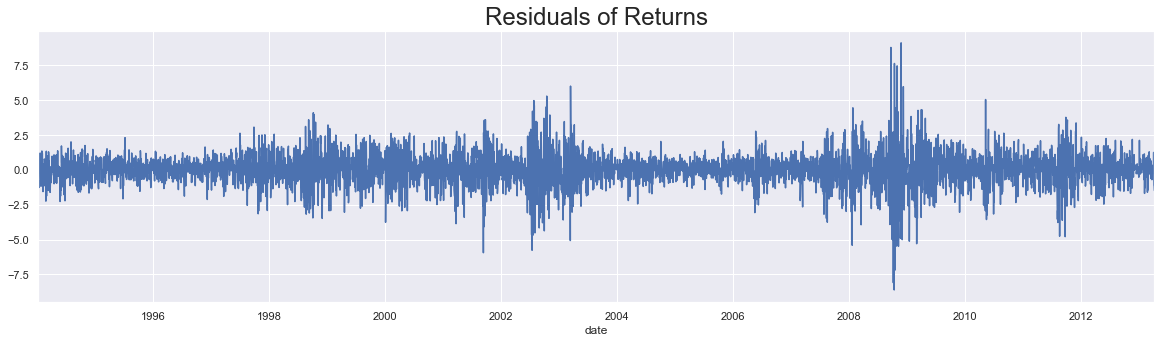

In [42]:
df.res_ret_ar_3_ma_2.plot(figsize = (20,5))
plt.title("Residuals of Returns", size = 24)
plt.show()

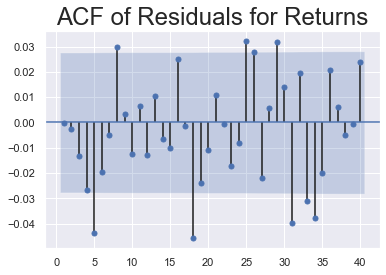

In [43]:
sgt.plot_acf(df.res_ret_ar_3_ma_2[2:], zero = False, lags = 40)
plt.title("ACF of Residuals for Returns", size=24)
plt.show()

In [44]:
#we have more significant lags than AR and MA models
#accounting for either returns or residuals 5 periods ago, could improve our predictions
#so we should opt for ARMA(5,5), ARMA(P,5) or ARMA(5,Q)

In [45]:
#ARMA(1,5) and ARMA(5,5) are the best (conclusion from the vid) and now we have to compare their LogLikelihood and
#AIC. We can't do LLR test, because they have the same number of DF

In [46]:
model_ret_ar_5_ma_1 = ARMA(df.returns[1:], order=(5,1))
results_ret_ar_5_ma_1 = model_ret_ar_5_ma_1.fit()
print(results_ret_ar_5_ma_1.summary())

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(5, 1)   Log Likelihood               -7889.311
Method:                       css-mle   S.D. of innovations              1.165
Date:                Thu, 18 Jun 2020   AIC                          15794.623
Time:                        16:22:33   BIC                          15846.792
Sample:                    01-10-1994   HQIC                         15812.903
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.013      1.407      0.159      -0.007       0.045
ar.L1.returns     0.3440      0.131      2.624      0.009       0.087       0.601
ar.L2.returns    -0.0458      0.015     

In [47]:
model_ret_ar_1_ma_5 = ARMA(df.returns[1:], order=(1,5))
results_ret_ar_1_ma_5 = model_ret_ar_1_ma_5.fit()
print(results_ret_ar_1_ma_5.summary())

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(1, 5)   Log Likelihood               -7890.973
Method:                       css-mle   S.D. of innovations              1.165
Date:                Thu, 18 Jun 2020   AIC                          15797.947
Time:                        16:22:57   BIC                          15850.116
Sample:                    01-10-1994   HQIC                         15816.228
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.013      1.419      0.156      -0.007       0.045
ar.L1.returns     0.3285      0.152      2.159      0.031       0.030       0.627
ma.L1.returns    -0.3534      0.152     

In [49]:
print("\nARMA(5,1): \tLL = ", results_ret_ar_5_ma_1.llf, "\tAIC = ", results_ret_ar_5_ma_1.aic)
print("\nARMA(1,5): \tLL = ", results_ret_ar_1_ma_5.llf, "\tAIC = ", results_ret_ar_1_ma_5.aic)


ARMA(5,1): 	LL =  -7889.311282946109 	AIC =  15794.622565892218

ARMA(1,5): 	LL =  -7890.973460209596 	AIC =  15797.946920419192


In [51]:
#ARMA(5,1)>ARMA(1,5)

In [53]:
#now we compare the two to choose the ultimate best

In [52]:
print("\nARMA(5,1): \tLL = ", results_ret_ar_5_ma_1.llf, "\tAIC = ", results_ret_ar_5_ma_1.aic)
print("\nARMA(3,2): \tLL = ", results_ret_ar_3_ma_2.llf, "\tAIC = ", results_ret_ar_3_ma_2.aic)


ARMA(5,1): 	LL =  -7889.311282946109 	AIC =  15794.622565892218

ARMA(3,2): 	LL =  -7895.747458514511 	AIC =  15805.494917029022


In [54]:
#ARMA(5,1) wins!

In [55]:
#AR has PACF, MA has ACF, but ARMA has no such a thing
#therefor we can make the mistake of starting off with a model, whose order is lower than the optimal one
#this is why examining the residuals is crucial to find the optimal ARMA model

Residuals for The New Model

In [56]:
df['res_ret_ar_5_ma_1'] = results_ret_ar_5_ma_1.resid

/Users/ninalewandowska/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


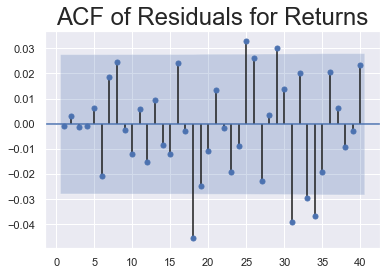

In [57]:
sgt.plot_acf(df.res_ret_ar_5_ma_1[2:], zero = False, lags = 40)
plt.title("ACF of Residuals for Returns", size=24)
plt.show()

In [59]:
#lags up to 18th are not significant
#if we want our model to resemble the data set more closely we could include even more lags to our model
#however, this will predespose the model to failure when facing unfamiliar data